In [1]:
import sys,os
import random
import numpy as np
import json
from collections import OrderedDict
from gnn import GNNNet
from utils import *
from emetrics import *
from data_process import create_dataset_for_5folds
import torch
import torch.nn as nn
from torch_geometric.data import DataLoader
import rdkit as rd
from torch_sparse import SparseTensor,transpose
import deepchem
import tensorflow as tf
import pandas as pd
import pickle

import os
import sys
import torch
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

from emetrics import get_aupr, get_cindex, get_rm2, get_ci, get_mse, get_rmse, get_pearson, get_spearman
from utils import *
from scipy import stats
from gnn import GNNNet
from data_process import create_dataset_for_test,create_dataset_for_test_bootstrap
import seaborn as sns


from statannotations.Annotator import Annotator #!pip install seaborn statannotations 

/disk/scratch/Protein_ContactMaps_DL_BindingAffinity/DGraphDTA/emetrics.py:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if pair is not 0:
RDKit WARNING: [21:45:01] Enabling RDKit 2019.09.3 jupyter extensions
[21:45:01] Enabling RDKit 2019.09.3 jupyter extensions


### Loading the Trained Model and Testing

In [5]:
datasets = ['davis', 'kiba'][1]
datasets 

'kiba'

In [6]:
def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            # data = data.to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()


def load_model(model_path):
    model = torch.load(model_path)
    return model


def calculate_metrics(Y, P, dataset='davis'):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)

    result_file_name = 'results/result_pconcs4_188_2000_' + model_st + '_' + dataset + '.txt'
    result_str = ''
    result_str += dataset + '\r\n'
    result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
        pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
    print(result_str)
    open(result_file_name, 'w').writelines(result_str)


def plot_density(Y, P, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    #plt.savefig(os.path.join('results', dataset + '_pconcs4_188_2000_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')

def calculate_metrics1(Y, P, dataset):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)
    return cindex,pearson,rmse,mse,rm2



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.device('cuda:0')
cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][0]
print('cuda_name:', cuda_name)

cuda_name: cuda:0


### Pconsc4

In [5]:
method=['pconsc4', 'esm_cmaps', 'alpha_fold_cmaps','rand_cmaps'][0]
method

'pconsc4'

In [6]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')

model_file_name = 'models_sample/model_kiba_pconsc4__188_2000_GNNNet_kiba_1.model' #change the model name from models_sample folder


model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))

GNNNet Loaded


<All keys matched successfully>

In [13]:
#bootstrapping the test data 
rmse1=[]
pearson1=[]
ci1=[]
mse1=[]
rm21=[]
niters=20

for i in range(niters):
    print(i)
    test_data = create_dataset_for_test_bootstrap(datasets, method,random=i)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
    Y, P = predicting(model, device, test_loader)
    cindex,pearson,rmse,mse,rm2=calculate_metrics1(Y, P, datasets)
    print(cindex,pearson,rmse)
    ci1.append(cindex)
    pearson1.append(pearson)
    rmse1.append(rmse)
    mse1.append(mse)
    rm21.append(rm2)




0
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187


/disk/scratch/Protein_ContactMaps_DL_BindingAffinity/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614009692239915
cindex2 0.8586131623377731
rm2: 0.6748056351909609
mse: 0.20832531
pearson 0.8233104587670739
0.8614009692239915 0.8233104587670739 0.456426677070433
1
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.851659576305958
cindex2 0.847633862081621
rm2: 0.5778387622577215
mse: 0.22758752
pearson 0.7780721303959903
0.851659576305958 0.7780721303959903 0.47706133890329283
2
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8559298108454405
cindex2 0.8586343755756322
rm2: 0.6281498543759381
mse: 0.23502246
pearson 0.8055174622959134
0.8559298108454405 0.8055174622959134 0.48479114622058916
3
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective pro

In [19]:
test_data = create_dataset_for_test(datasets,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
Y_1, P_1 = predicting(model, device, test_loader)

dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 15908 samples...


In [8]:
#write the results to .txt file 
name=method+"_2000_188"
result_file_name = 'results2/' + name + '.txt'

result_str = ''
result_str += datasets + '\r\n'
result_str += 'rmse:' + str(np.mean(rmse1)) + ' ' + ' mse:' + str(np.mean(mse1)) + ' ' + ' pearson:' + str(
         np.mean(pearson1)) + ' '  + 'ci:' + str(np.mean(ci1)) + ' ' + 'rm2:' + str(np.mean(rm21))
print(result_str)
open(result_file_name, 'w').writelines(result_str)

kiba
rmse:0.46627464485146397  mse:0.21796775  pearson:0.8269275117108792 ci:0.860688653895836 rm2:0.6669443882199839


In [9]:
name=method+"_2000_188_Y"
result_file_name = 'results2/' + name + '.txt'
with open(result_file_name, 'w') as f:
    for item in Y:
        f.write("%s\n" % item)

In [10]:
name=method+"_2000_188_P"
result_file_name = 'results2/' + name + '.txt'
with open(result_file_name, 'w') as f:
    for item in P:
        f.write("%s\n" % item)

### ESM

In [20]:
method=['pconsc4', 'esm_cmaps', 'alpha_fold_cmaps','rand_cmaps'][1]
method

'esm_cmaps'

In [9]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_esm__188_2000_GNNNet_kiba_1.model'
#result_file_name = 'results/resul_pconsc4__188_2000_' + model_st + '_' + dataset + '.txt'

model1 = GNNNet()
model1.to(device)
model1.load_state_dict(torch.load(model_file_name, map_location=cuda_name))

GNNNet Loaded


<All keys matched successfully>

In [10]:
rmse2=[]
pearson2=[]
ci2=[]
mse2=[]
rm22=[]
niters=20

for i in range(niters):
    print(i)
    test_data = create_dataset_for_test_bootstrap(datasets, method,random=i)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
    Y2, P2 = predicting(model1, device, test_loader)
    cindex,pearson,rmse,mse,rm2=calculate_metrics1(Y2, P2, datasets)
    print(cindex,pearson,rmse)
    ci2.append(cindex)
    pearson2.append(pearson)
    rmse2.append(rmse)
    mse2.append(mse)
    rm22.append(rm2)




0
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8440178740008811
cindex2 0.8467392601940754
rm2: 0.6206101529951987
mse: 0.21394388
pearson 0.8199585504464736
0.8440178740008811 0.8199585504464736 0.4625406833746246
1
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8351178007644633
cindex2 0.8442134282434376
rm2: 0.5905512128556027
mse: 0.21153486
pearson 0.7961210442635523
0.8351178007644633 0.7961210442635523 0.459929187756049
2
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8332529806502053
cindex2 0.8358007873577251
rm2: 0.6108695013276704
mse: 0.2538581
pearson 0.787238669470584
0.8332529806502053 0.787238669470584 0.5038433

In [22]:
test_data = create_dataset_for_test(datasets,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
Y_2, P_2 = predicting(model1, device, test_loader)

dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 15908 samples...


### Alphafold 

In [23]:
method=['pconsc4', 'esm_cmaps', 'alpha_fold_cmaps','rand_cmaps'][2]
method

'alpha_fold_cmaps'

In [24]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_alpha__188_2000_GNNNet_kiba_1.model'
#result_file_name = 'results/resul_pconsc4__188_2000_' + model_st + '_' + dataset + '.txt'

model2 = GNNNet()
model2.to(device)
model2.load_state_dict(torch.load(model_file_name, map_location=cuda_name))

GNNNet Loaded


<All keys matched successfully>

In [13]:
rmse3=[]
pearson3=[]
ci3=[]
mse3=[]
rm23=[]
niters=20

for i in range(niters):
    print(i)
    test_data = create_dataset_for_test_bootstrap(datasets, method,random=i)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
    Y3, P3 = predicting(model2, device, test_loader)
    cindex,pearson,rmse,mse,rm2=calculate_metrics1(Y3, P3, datasets)
    print(cindex,pearson,rmse)
    ci3.append(cindex)
    pearson3.append(pearson)
    rmse3.append(rmse)
    mse3.append(mse)
    rm23.append(rm2)




0
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8430612373340046
cindex2 0.8445861827856131
rm2: 0.6643854152846679
mse: 0.21637936
pearson 0.8156796850680887
0.8430612373340046 0.8156796850680887 0.4651659481996824
1
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8343835705184961
cindex2 0.8318268914807085
rm2: 0.5712121050674861
mse: 0.23630813
pearson 0.7675312695799118
0.8343835705184961 0.7675312695799118 0.48611534396856665
2
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8459747649141095
cindex2 0.8451801112924575
rm2: 0.5895319416254478
mse: 0.25562683
pearson 0.7866772884965546
0.8459747649141095 0.7866772884965546 0.50

In [25]:
test_data = create_dataset_for_test(datasets,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
Y_3, P_3 = predicting(model2, device, test_loader)

dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 15908 samples...


### Random Cmaps

In [26]:
method=['pconsc4', 'esm_cmaps', 'alpha_fold_cmaps','rand_cmaps'][3]
method

'rand_cmaps'

In [15]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_random_188_2000_GNNNet_kiba_1.model'
#result_file_name = 'results/resul_pconsc4__188_2000_' + model_st + '_' + dataset + '.txt'

model3 = GNNNet()
model3.to(device)
model3.load_state_dict(torch.load(model_file_name, map_location=cuda_name))

GNNNet Loaded


<All keys matched successfully>

In [16]:
rmse4=[]
pearson4=[]
ci4=[]
mse4=[]
rm24=[]
niters=20

for i in range(niters):
    print(i)
    test_data = create_dataset_for_test_bootstrap(datasets, method,random=i)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
    Y4, P4 = predicting(model3, device, test_loader)
    cindex,pearson,rmse,mse,rm2=calculate_metrics1(Y4, P4, datasets)
    print(cindex,pearson,rmse)
    ci4.append(cindex)
    pearson4.append(pearson)
    rmse4.append(rmse)
    mse4.append(mse)
    rm24.append(rm2)

0
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.851480059580003
cindex2 0.848276259017344
rm2: 0.6374052289774804
mse: 0.23088366
pearson 0.8013546921449163
0.851480059580003 0.8013546921449163 0.48050354622237856
1
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8343446995054743
cindex2 0.8374131022033312
rm2: 0.5643348863023364
mse: 0.2330264
pearson 0.7715859464897759
0.8343446995054743 0.7715859464897759 0.4827280810233368
2
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8455751731926076
cindex2 0.8477268151422855
rm2: 0.6396119915295829
mse: 0.23686211
pearson 0.8033103356803317
0.8455751731926076 0.8033103356803317 0.486684

In [27]:
test_data = create_dataset_for_test(datasets,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
Y_4, P_4 = predicting(model3, device, test_loader)

dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 15908 samples...


### Plots

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

In [47]:
sns.set_theme(style="whitegrid")

#### Box Plots for each metric comparing various cmap methods

##### Concordance Index

In [ ]:
# Run this cell only if the you have run all the tests above or you can use directly load from pickle file as shown below
data_1 = ci1
data_2 = ci2
data_3 = ci3
data_4= ci4

data_ci1 = [data_1, data_2, data_3,data_4]
data_ci = pd.DataFrame(
{'Pconsc4':data_1,
 'ESM': data_2,
 'AlphaFold': data_3,
 'Random':data_4
})

##### or

In [12]:
data_ci  = pd.read_pickle('results_KIBA/Test_set_result_plots/ci.pkl') 

In [29]:
sns.set_theme(style="whitegrid")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pconsc4 vs. ESM: t-test paired samples, P_val:6.304e-03 t=3.070e+00
ESM vs. AlphaFold: t-test paired samples, P_val:4.738e-03 t=3.198e+00
AlphaFold vs. Random: t-test paired samples, P_val:3.308e-03 t=-3.357e+00
Pconsc4 vs. AlphaFold: t-test paired samples, P_val:6.436e-08 t=8.525e+00
ESM vs. Random: t-test paired samples, P_val:8.948e-01 t=1.341e-01
Pconsc4 vs. Random: t-test paired samples, P_val:1.247e-03 t=3.787e+00


(<AxesSubplot:title={'center':'Evaluation- Concodance Index'}, xlabel='Concordance Index', ylabel='Scores'>,
  <statannotations.Annotation.Annotation at 0x7f0ccea502e0>])

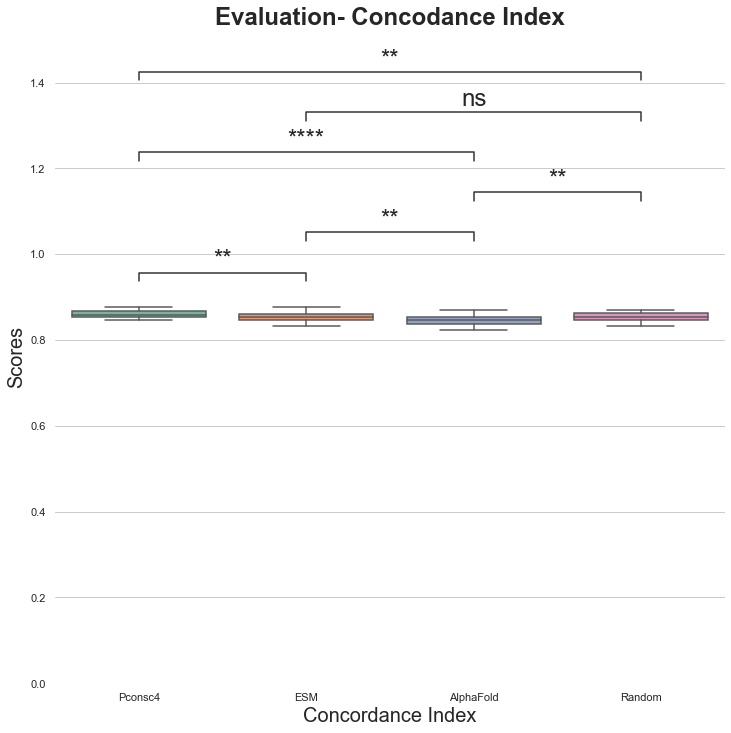

In [19]:
f, ax = plt.subplots(figsize=(12, 12))

# Draw a violinplot with a narrower bandwidth than the default
order = ['Pconsc4', 'ESM', 'AlphaFold', 'Random']
pairs=[("Pconsc4", "ESM"), ("ESM", "AlphaFold"), ("AlphaFold", "Random"),("Pconsc4", "Random"),("Pconsc4", "AlphaFold"),("ESM", "Random")]
sns.set(font_scale = 2)
ax=sns.boxplot(data=data_ci, palette="Set2",order=order)

# Finalize the figure
ax.set(ylim=(0, 1))
ax.margins(x=2, y=2)
ax.set_xlabel('Concordance Index',fontsize=20)
ax.set_ylabel('Scores',fontsize=20)
ax.set_title('Evaluation- Concodance Index',fontsize=24,fontweight='bold')
sns.despine(left=True, bottom=True)
annotator = Annotator(ax, pairs, data=data_ci, order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside')
annotator.apply_and_annotate()
# plt.savefig(os.path.join('results2',  'boxplot_CI_188_2000' + '.png'), dpi=500, bbox_inches='tight')
# plt.savefig(os.path.join('results2',  'boxplot_CI_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

##### RMSE

In [ ]:
data_1 = rmse1
data_2 = rmse2
data_3 = rmse3
data_4= rmse4

data_rmse1 = [data_1, data_2, data_3,data_4]
data_rmse = pd.DataFrame(
{'Pconsc4':data_1,
 'ESM': data_2,
 'AlphaFold': data_3,
 'Random':data_4
})

In [22]:
data_rmse  = pd.read_pickle('results_KIBA/Test_set_result_plots/rmse.pkl') 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pconsc4 vs. ESM: t-test paired samples, P_val:8.118e-01 t=-2.414e-01
ESM vs. AlphaFold: t-test paired samples, P_val:7.449e-04 t=-4.012e+00
AlphaFold vs. Random: t-test paired samples, P_val:8.159e-03 t=2.954e+00
Pconsc4 vs. AlphaFold: t-test paired samples, P_val:3.550e-04 t=-4.337e+00
ESM vs. Random: t-test paired samples, P_val:5.026e-02 t=-2.090e+00
Pconsc4 vs. Random: t-test paired samples, P_val:2.339e-03 t=-3.511e+00


(<AxesSubplot:title={'center':'Evaluation- RMSE'}, xlabel='RMSE', ylabel='Scores'>,
  <statannotations.Annotation.Annotation at 0x7f0cce7f0c70>])

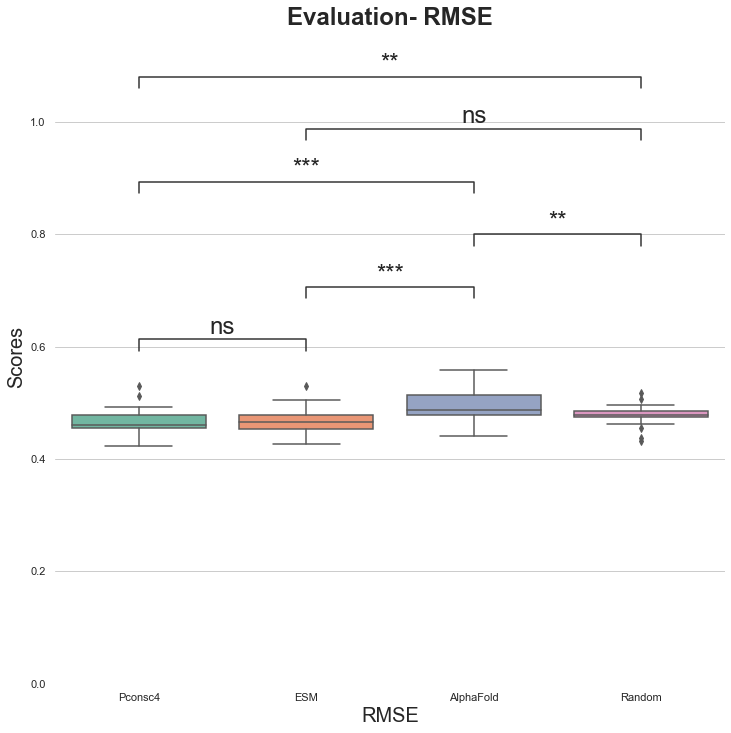

In [25]:
f, ax = plt.subplots(figsize=(12, 12))

# Draw a violinplot with a narrower bandwidth than the default
order = ['Pconsc4', 'ESM', 'AlphaFold', 'Random']
pairs=[("Pconsc4", "ESM"), ("ESM", "AlphaFold"), ("AlphaFold", "Random"),("Pconsc4", "Random"),("Pconsc4", "AlphaFold"),("ESM", "Random")]
sns.set(font_scale = 2)

ax=sns.boxplot(data=data_rmse, palette="Set2",order=order)

# Finalize the figure
ax.set(ylim=(0, 1))
ax.margins(x=2, y=2)
ax.set_xlabel('RMSE',fontsize=20)
ax.set_ylabel('Scores',fontsize=20)
ax.set_title('Evaluation- RMSE',fontsize=24,fontweight='bold')
sns.despine(left=True, bottom=True)
annotator = Annotator(ax, pairs, data=data_rmse, order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside')
annotator.apply_and_annotate()
# plt.savefig(os.path.join('results2',  'boxplot_rmse_188_2000' + '.png'), dpi=500, bbox_inches='tight')
# plt.savefig(os.path.join('results2',  'boxplot_rmse_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

###### Pearson

In [26]:
data_pearson  = pd.read_pickle('results_KIBA/Test_set_result_plots/pearson.pkl')

In [ ]:
data_1 = pearson1
data_2 = pearson2
data_3 = pearson3
data_4= pearson4

data_pearson1 = [data_1, data_2, data_3,data_4]
data_pearson = pd.DataFrame(
{'Pconsc4':data_1,
 'ESM': data_2,
 'AlphaFold': data_3,
 'Random':data_4
})

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pconsc4 vs. ESM: t-test paired samples, P_val:7.882e-01 t=-2.724e-01
ESM vs. AlphaFold: t-test paired samples, P_val:3.516e-04 t=4.341e+00
AlphaFold vs. Random: t-test paired samples, P_val:5.362e-03 t=-3.142e+00
Pconsc4 vs. AlphaFold: t-test paired samples, P_val:2.464e-04 t=4.498e+00
ESM vs. Random: t-test paired samples, P_val:3.230e-02 t=2.310e+00
Pconsc4 vs. Random: t-test paired samples, P_val:4.077e-03 t=3.265e+00


(<AxesSubplot:title={'center':'Evaluation- Pearson'}, xlabel='Pearson', ylabel='Scores'>,
  <statannotations.Annotation.Annotation at 0x7f0cbf628dc0>])

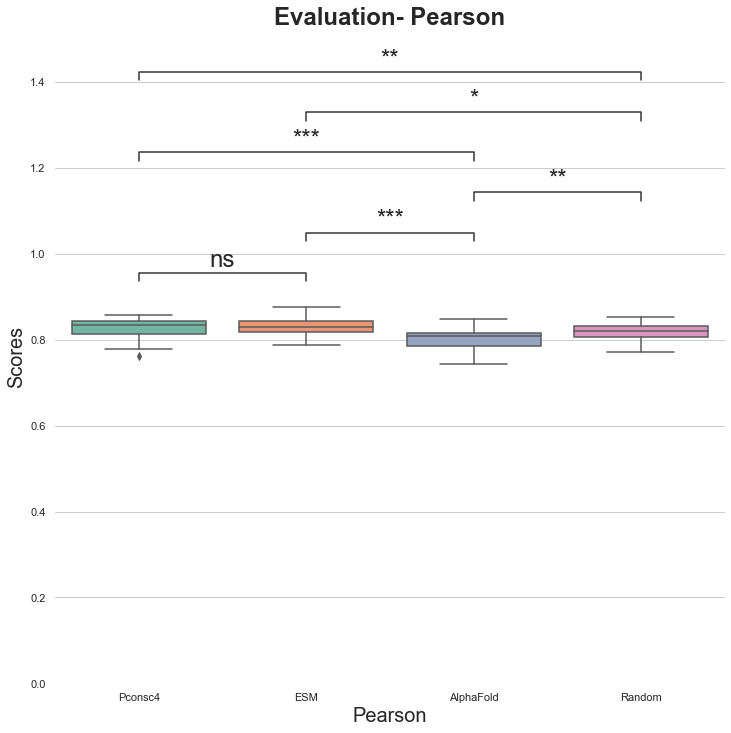

In [30]:
f, ax = plt.subplots(figsize=(12, 12))

# Draw a violinplot with a narrower bandwidth than the default
order = ['Pconsc4', 'ESM', 'AlphaFold', 'Random']
pairs=[("Pconsc4", "ESM"), ("ESM", "AlphaFold"), ("AlphaFold", "Random"),("Pconsc4", "Random"),("Pconsc4", "AlphaFold"),("ESM", "Random")]
sns.set(font_scale = 2)
ax=sns.boxplot(data=data_pearson, palette="Set2",order=order)

# Finalize the figure
ax.set(ylim=(0, 1))
ax.margins(x=2, y=2)
ax.set_xlabel('Pearson',fontsize=20)
ax.set_ylabel('Scores',fontsize=20)
ax.set_title('Evaluation- Pearson',fontsize=24,fontweight='bold')
sns.despine(left=True, bottom=True)
annotator = Annotator(ax, pairs, data=data_pearson, order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside')
annotator.apply_and_annotate()
# plt.savefig(os.path.join('results2',  'boxplot_pearson1_188_2000' + '.png'), dpi=500, bbox_inches='tight')
# plt.savefig(os.path.join('results2',  'boxplot_pearson1_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

## Density Plots

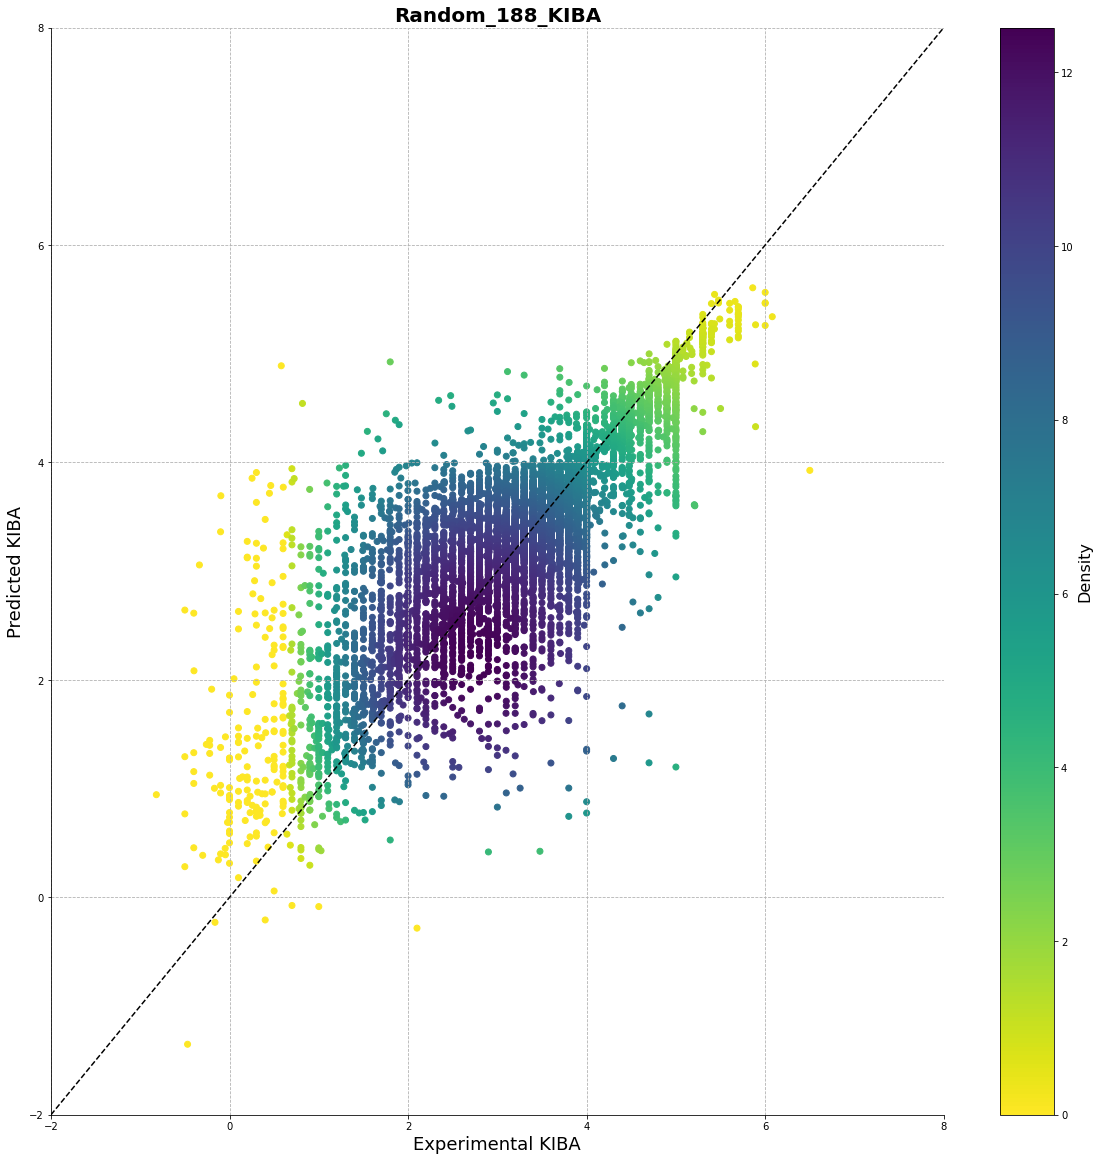

In [31]:
x = Y_4 #Groundtruths list to be set based on the method
y = P_4 #predictions list to be set based on the method

f, ax = plt.subplots(figsize=(20, 20))
plt.grid(linestyle='--')
data , x_e, y_e = np.histogram2d( x, y, bins = [5,5], density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#To be sure to plot all data
z[np.where(np.isnan(z))] = 0.0
# Sort the points by density, so that the densest points are plotted last
sort= True
if sort:
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter( x, y, c=z,cmap='viridis_r')

norm = Normalize(vmin = np.min(z)*100, vmax = np.max(z)*100)
cbar = f.colorbar(cm.ScalarMappable(norm = norm,cmap='viridis_r'), ax=ax)
cbar.ax.set_ylabel('Density',fontsize=16)
#ax.scatter(x, y, c=z, s=10)
plt.plot([-2, 8], [-2, 8], color='black',linestyle="--")
ax.set(ylim=(-2, 8))
ax.set(xlim=(-2,8))
ax.set_ylabel('Predicted KIBA',fontsize=18)
ax.set_xlabel('Experimental KIBA',fontsize=18)
ax.set_title('Random_188_KIBA',fontsize=20,fontweight='bold') 
leg = plt.gca().get_legend()
plt.show()
# f.savefig(os.path.join('results2',  'densityPlot_random_188_2000' + '.png'), dpi=500, bbox_inches='tight')
# f.savefig(os.path.join('results2',  'densityPlot_random_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')


### Experimental vs Predicted KIBA score comparision 

In [48]:
data_exps={
    'Experimental_KIBA': Y_2, #Groundtruths list to be set based on the method
    'Predicted_KIBA': P_2 #Predictions list to be set based on the method
}

/home/co-gora1/rds/hpc-work/miniconda3/envs/mldd1/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


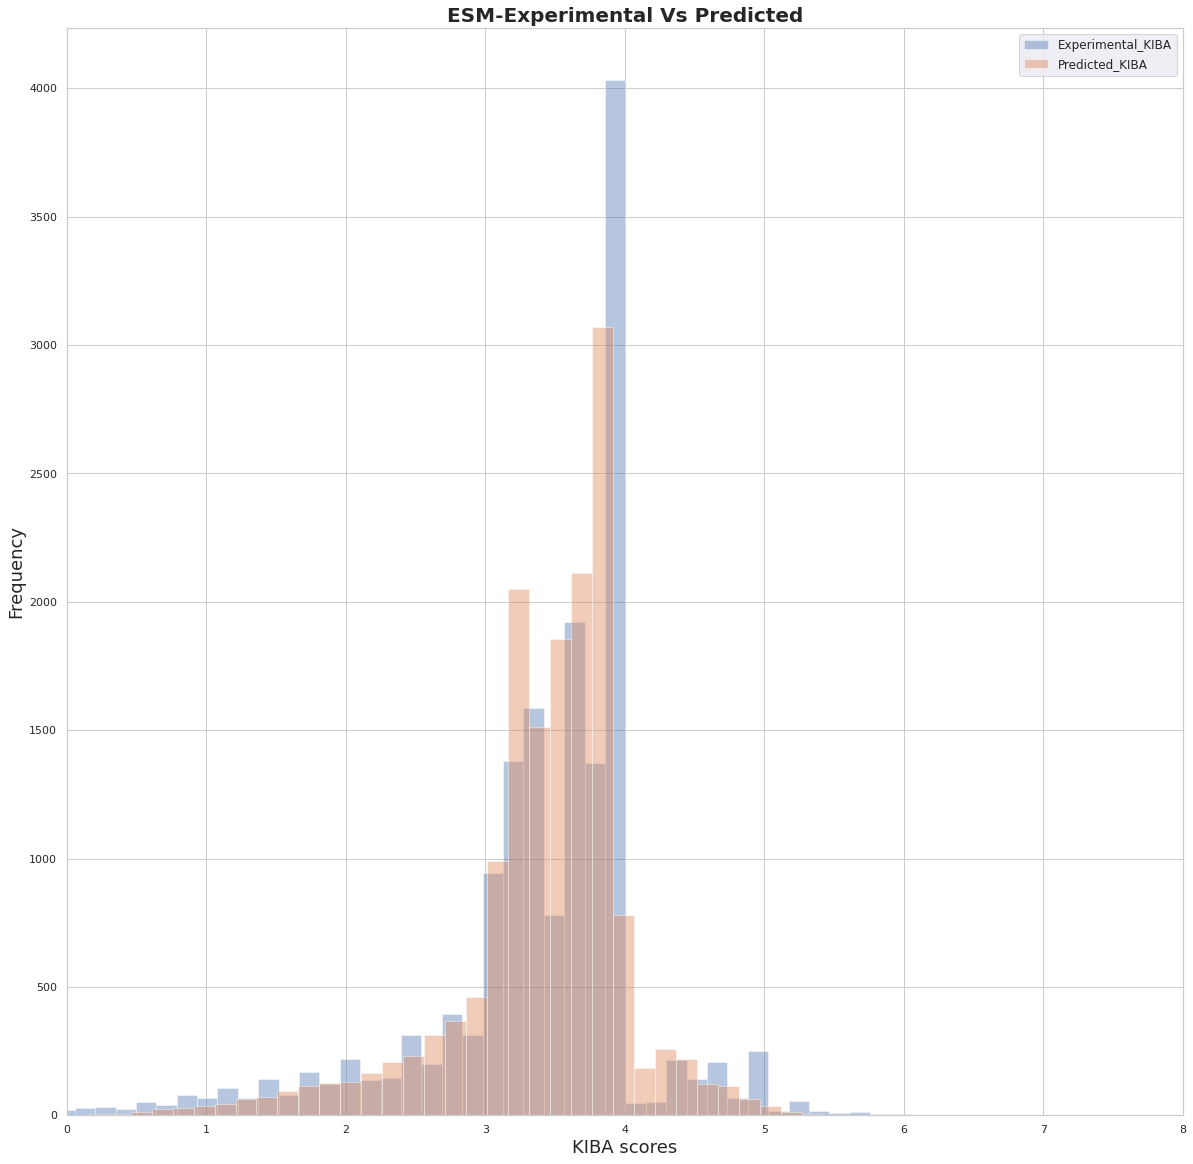

In [49]:
f, ax = plt.subplots(figsize=(20, 20))

sns.set(font_scale = 2)
sns.distplot(data_exps['Experimental_KIBA'],  kde=False,label='Experimental_KIBA',bins=100)
sns.distplot(data_exps['Predicted_KIBA'],  kde=False,label='Predicted_KIBA',bins=100)
ax.legend(prop={'size': 12})
ax.set_title('ESM-Experimental Vs Predicted',fontsize=20,fontweight='bold')
ax.set_xlabel('KIBA scores',fontsize=18)
ax.set(xlim=(0,8))
ax.set_ylabel('Frequency',fontsize=18)
plt.show()
f.savefig(os.path.join('results2',  'hist_esm_188_2000' + '.png'), dpi=500, bbox_inches='tight')
f.savefig(os.path.join('results2',  'hist_esm_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

### Error Plot -- 200 randomly selected points

In [73]:
n = 200  # for 2 random indices
np.random.seed(15)
index = np.random.choice(len(Y), n, replace=False)  
x_random = P4[index] #Predictions list to be set based on the method
y_random = Y4[index] #Groundtruths list to be set based on the method
totalers_random=totalers[index]

In [74]:
sns.set_theme(style="whitegrid")

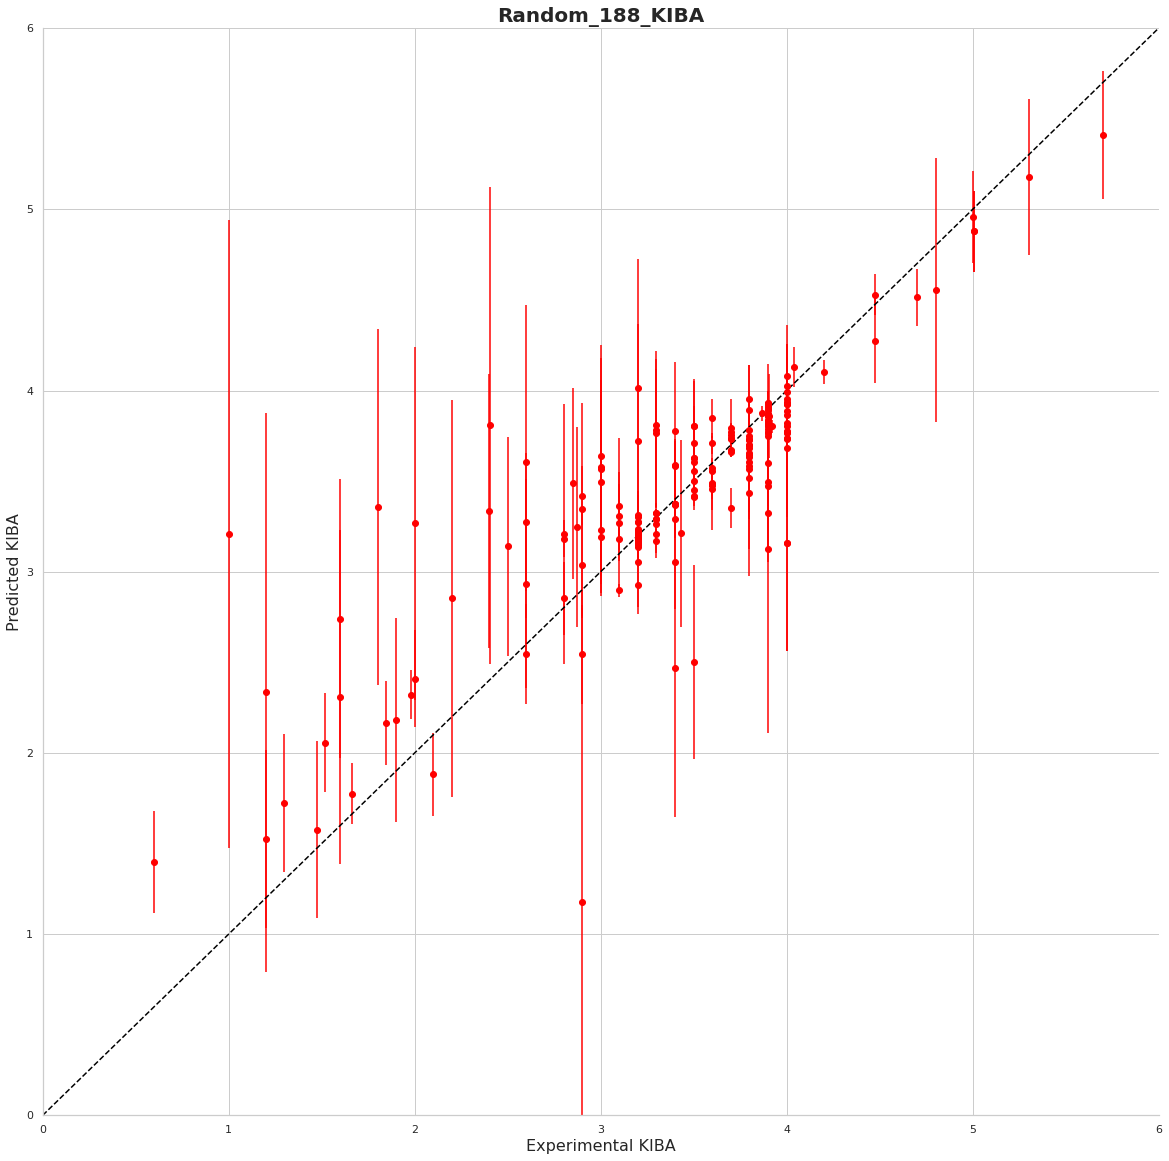

In [75]:
f, ax = plt.subplots(figsize=(20, 20))
#plt.grid(linestyle='--')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.errorbar( y_random, x_random, yerr=totalers_random, fmt="o", color="red")
plt.plot([0, 6], [0, 6], color='black',linestyle="--")
ax.set(ylim=(0, 6))
ax.set(xlim=(0,6))
ax.set_ylabel('Predicted KIBA',fontsize=16)
ax.set_xlabel('Experimental KIBA',fontsize=16)
leg = plt.gca().get_legend()
#ltext = leg.get_texts()
ax.set_title('Random_188_KIBA',fontsize=20,fontweight='bold')  
plt.show()
f.savefig(os.path.join('results2',  'error_plot_Random_188_2000' + '.png'), dpi=500, bbox_inches='tight')
f.savefig(os.path.join('results2',  'error_plot_Random_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')